### Importing necessary Modules for database and name generation

In [84]:
from pymongo import MongoClient
import random
import string
import psutil
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import mannwhitneyu
import os
from math import pi

#brew services start mongodb-community@6.0


#### Connecting to the mongodb on standard localhost 

This code connects to the user_info_db database and retrieves the user_info collection


In [70]:
# Connect to MongoDB (default host and port: localhost:27017)
client = MongoClient('mongodb://localhost:27017/')
# Create or access the 'user_info_db' database
db = client['user_info_db']

Initializing the collections used



In [71]:
collection_50 = db['user_info_50']
collection_500 = db['user_info_500']
collection_5000 = db['user_info_5000']

grover_search_50 = db['grover_search_50']  
grover_search_500 = db['grover_search_500']
grover_search_5000 = db['grover_search_5000']


Helper function to generate names

In [72]:
def generate_random_name(length=6):
    """Generate a random name of a specified length"""
    return ''.join(random.choices(string.ascii_uppercase, k=length))

### All collection insertions

In [73]:
# Insertion function for 'user_info_50'
def insert_user_info_50():
    collection_50.delete_many({})  # Clear any existing data
    names_50 = [{"name": generate_random_name()} for _ in range(50)]
    collection_50.insert_many(names_50)
    print("Inserted 50 names into user_info_50.")

# Insertion function for 'user_info_500'
def insert_user_info_500():
    collection_500.delete_many({})  # Clear any existing data
    names_500 = [{"name": generate_random_name()} for _ in range(500)]
    collection_500.insert_many(names_500)
    print("Inserted 500 names into user_info_500.")

# Insertion function for 'user_info_5000'
def insert_user_info_5000():
    collection_5000.delete_many({})  # Clear any existing data
    names_5000 = [{"name": generate_random_name()} for _ in range(5000)]
    collection_5000.insert_many(names_5000)
    print("Inserted 5000 names into user_info_5000.")

# inserting
insert_user_info_50()
insert_user_info_500()
insert_user_info_5000()



Inserted 50 names into user_info_50.
Inserted 500 names into user_info_500.
Inserted 5000 names into user_info_5000.


### Creating the target lists

In [74]:
# Step 2: Create the target name lists
# Helper function to create target lists (existing + non-existing names)
def create_target_name_list(collection_name, total_names):
    collection = db[collection_name]
    existing_names = [user["name"] for user in collection.find()]
    print(f"Existing names in {collection_name}: {existing_names[:10]}")  # Displaying first 10 names for inspection
    
    # Generate non-existing names
    new_non_existing_names = set()
    while len(new_non_existing_names) < total_names // 2:  # Half will be non-existing
        new_name = generate_random_name()
        if new_name not in existing_names:
            new_non_existing_names.add(new_name)
    
    target_name_list = existing_names[:total_names // 2] + list(new_non_existing_names)
    random.shuffle(target_name_list)  # Shuffle the list to mix existing and new names
    return target_name_list

# Creating target name lists
target_name_list_50 = create_target_name_list('user_info_50', 100)
target_name_list_500 = create_target_name_list('user_info_500', 1000)
target_name_list_5000 = create_target_name_list('user_info_5000', 10000)

# Verifying the lists
print(f"Target name list for user_info_50 (100 names): {target_name_list_50[:10]}...")  # Displaying first 10 names for inspection
print(f"Target name list for user_info_500 (1000 names): {target_name_list_500[:10]}...")
print(f"Target name list for user_info_5000 (10000 names): {target_name_list_5000[:10]}...")

Existing names in user_info_50: ['NKBFXC', 'BJABKG', 'NZPBQI', 'SPPPAW', 'FIZNCA', 'TRKPJO', 'PCSGSX', 'LQBHQP', 'XISWQD', 'POTUKG']
Existing names in user_info_500: ['ODIHGO', 'ZNLCPA', 'BYTZOA', 'UOPELY', 'KRUCGF', 'ZHNEGT', 'FRJTYP', 'FBCLVU', 'IISULS', 'AMWXEX']
Existing names in user_info_5000: ['WSYWGP', 'USDHAD', 'SPZLUF', 'ICHBUO', 'LZENGQ', 'MNFMHH', 'FPLBSL', 'RXXPWY', 'UTUCED', 'FMCVSV']
Target name list for user_info_50 (100 names): ['YKVRRJ', 'QTCZJN', 'XFVUKI', 'EDNMYR', 'NDJHKD', 'DVIMAI', 'TEYOWO', 'QHZRJZ', 'BOWCRI', 'AGKKRQ']...
Target name list for user_info_500 (1000 names): ['QVTMQW', 'QOKGXD', 'IIVOLM', 'CUOBMP', 'DJKXCV', 'TCPTYO', 'KLFMAV', 'ONIXLC', 'KNCXTW', 'ZYYJLQ']...
Target name list for user_info_5000 (10000 names): ['EOZNDZ', 'RDCHRX', 'GMFHQO', 'GKVTYB', 'IDHSVY', 'VJJKSZ', 'BZZLEY', 'HOPPWN', 'FPHVJQ', 'SIZGYY']...


## Grovers Search below

In [75]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit.circuit.library import MCXGate

In [111]:
def grover_search_algorithm(collection, target_name_list, grover_collection):
    names = [user["name"] for user in collection.find()]
    name_to_index = {name: i for i, name in enumerate(names)}
    grover_collection.delete_many({})

    n = len(names)
    n_qubits = int(np.ceil(np.log2(n)))  # Number of qubits needed
    print(f"number of qubits: {n_qubits}")

    def grover_oracle(circuit, n_qubits, target_index):
        """Mark the state corresponding to the target index with a phase flip."""
        for qubit in range(n_qubits):
            if (target_index >> qubit) & 1:
                circuit.x(qubit)
        circuit.h(n_qubits - 1)
        circuit.mcx(list(range(n_qubits - 1)), n_qubits - 1)
        circuit.h(n_qubits - 1)
        for qubit in range(n_qubits):
            if (target_index >> qubit) & 1:
                circuit.x(qubit)

    def grover_diffusion(circuit, n_qubits):
        """Apply the diffusion operator."""
        for qubit in range(n_qubits):
            circuit.h(qubit)
            circuit.x(qubit)
        circuit.h(n_qubits - 1)
        circuit.mcx(list(range(n_qubits - 1)), n_qubits - 1)
        circuit.h(n_qubits - 1)
        for qubit in range(n_qubits):
            circuit.x(qubit)
            circuit.h(qubit)

    def insert_search_result(target_name, found, time_taken, cpu_time_used, memory_usage, num_iterations):
        """Insert the search result into MongoDB."""
        document = {
            "TargetName": target_name,
            "Found": found,
            "TimeTaken": time_taken,
            "CPUTimeUsed": cpu_time_used,  # Improved tracking
            "MemoryUsage": memory_usage,
            "num_iterations": num_iterations
        }
        grover_collection.insert_one(document)

    def grover_search_and_insert(names, target_name):
        n = len(names)
        n_qubits = int(np.ceil(np.log2(n)))  
        qc = QuantumCircuit(n_qubits, n_qubits)
        qc.h(range(n_qubits))

        target_index = name_to_index.get(target_name, None)
        found = target_index is not None

        if found:
            grover_oracle(qc, n_qubits, target_index)
            grover_diffusion(qc, n_qubits)

        qc.measure(range(n_qubits), range(n_qubits))
        simulator = AerSimulator()

        # Start tracking resources
        process = psutil.Process()
        cpu_start = process.cpu_times()  # Get CPU times (user + system)
        memory_start = process.memory_info().rss / (1024 * 1024)  # Memory in MB
        start_time = time.perf_counter()

        result = simulator.run(qc, shots=1024).result()

        elapsed_time = time.perf_counter() - start_time  # Time in seconds
        cpu_end = process.cpu_times()
        memory_end = process.memory_info().rss / (1024 * 1024)  # Memory in MB

        # Calculate CPU time used (user + system time)
        cpu_time_used = (cpu_end.user + cpu_end.system) - (cpu_start.user + cpu_start.system)
        memory_usage = memory_end - memory_start

        num_iterations = int(np.pi / 4 * np.sqrt(2 ** n_qubits))

        counts = result.get_counts(qc)
        if found:
            binary_target = format(target_index, f'0{n_qubits}b')
            found = binary_target in counts

        insert_search_result(target_name, found, elapsed_time, cpu_time_used, memory_usage, num_iterations)

    for target_name in target_name_list:
        grover_search_and_insert(names, target_name)

grover_search_algorithm(collection_50, target_name_list_50, grover_search_50)
grover_search_algorithm(collection_500, target_name_list_500, grover_search_500)
grover_search_algorithm(collection_5000, target_name_list_5000, grover_search_5000)

print("Grover finished")

number of qubits: 6
number of qubits: 9
number of qubits: 13
Grover finished


### Organizing the data

In [113]:
# Function to retrieve data from a collection
def get_search_data(collection_name):
    collection = db[collection_name]
    search_results = collection.find()  # Query all documents
    return list(search_results)

# Retrieve data for the grover_search_50, grover_search_500, and grover_search_5000 collections
data_grover_50 = get_search_data('grover_search_50')
data_grover_500 = get_search_data('grover_search_500')
data_grover_5000 = get_search_data('grover_search_5000')

# Extract times and found status for plotting
def extract_metrics(data):
    times = []
    found = []
    cpu_usage = []
    memory_usage = []
    num_iterations = []

    for record in data:
        times.append(record['TimeTaken'])
        found.append(record['Found'])
        cpu_usage.append(record['CPUTimeUsed'])
        memory_usage.append(record['MemoryUsage'])
        num_iterations.append(record['num_iterations'])
    
    return times, found, cpu_usage, memory_usage, num_iterations

dataset_sizes = [50, 500, 5000]
# Extract data for all three collections
times_grover_50, found_grover_50, cpu_grover_50, mem_grover_50, comp_grover_50 = extract_metrics(data_grover_50)
times_grover_500, found_grover_500, cpu_grover_500, mem_grover_500, comp_grover_500 = extract_metrics(data_grover_500)
times_grover_5000, found_grover_5000, cpu_grover_5000, mem_grover_5000, comp_grover_5000 = extract_metrics(data_grover_5000)



### Plotting the data

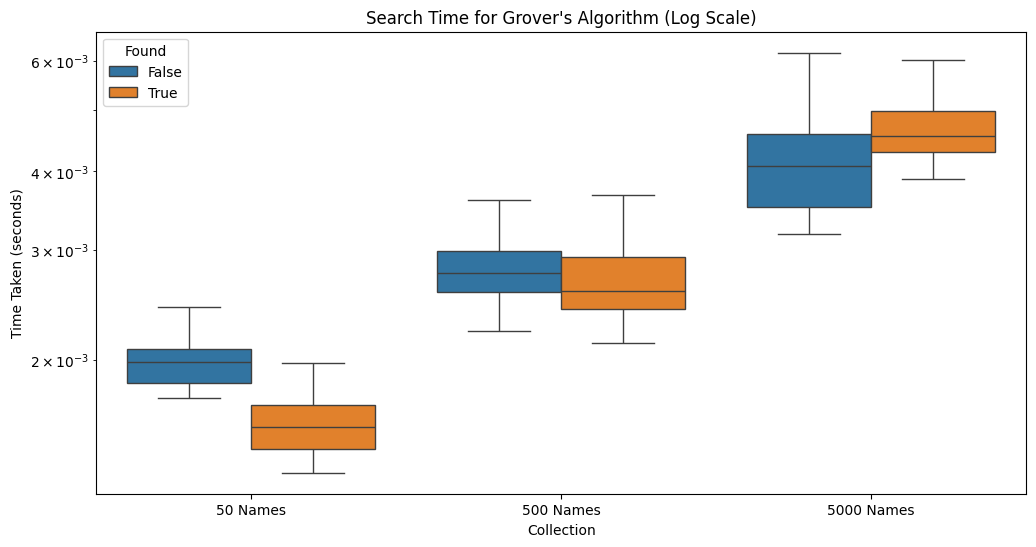

In [114]:
# Function to create DataFrame for plotting
def create_df_for_plot(times, found, cpu_usage, memory_usage, num_iterations, collection_name):
    df = pd.DataFrame({
        'Time Taken (seconds)': times,
        'CPU Usage (%)': cpu_usage,
        'Memory Usage (MB)': memory_usage,
        'num_iterations': num_iterations,
        'Found': found,
        'Collection': [collection_name] * len(times)
    })
    return df


# Create DataFrames for all collections
df_grover_50 = create_df_for_plot(times_grover_50, found_grover_50, cpu_grover_50, mem_grover_50, comp_grover_50, '50 Names')
df_grover_500 = create_df_for_plot(times_grover_500, found_grover_500, cpu_grover_500, mem_grover_500, comp_grover_500, '500 Names')
df_grover_5000 = create_df_for_plot(times_grover_5000, found_grover_5000, cpu_grover_5000, mem_grover_5000, comp_grover_5000, '5000 Names')

# Combine the DataFrames
df_all = pd.concat([df_grover_50, df_grover_500, df_grover_5000], ignore_index=True)

# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(x='Collection', y='Time Taken (seconds)', hue='Found', data=df_all, showfliers=False)
plt.yscale('log')  # Apply logarithmic scale
plt.title('Search Time for Grover\'s Algorithm (Log Scale)')
plt.ylabel('Time Taken (seconds)')
plt.show()


### Cpu, Memory and num_iterations

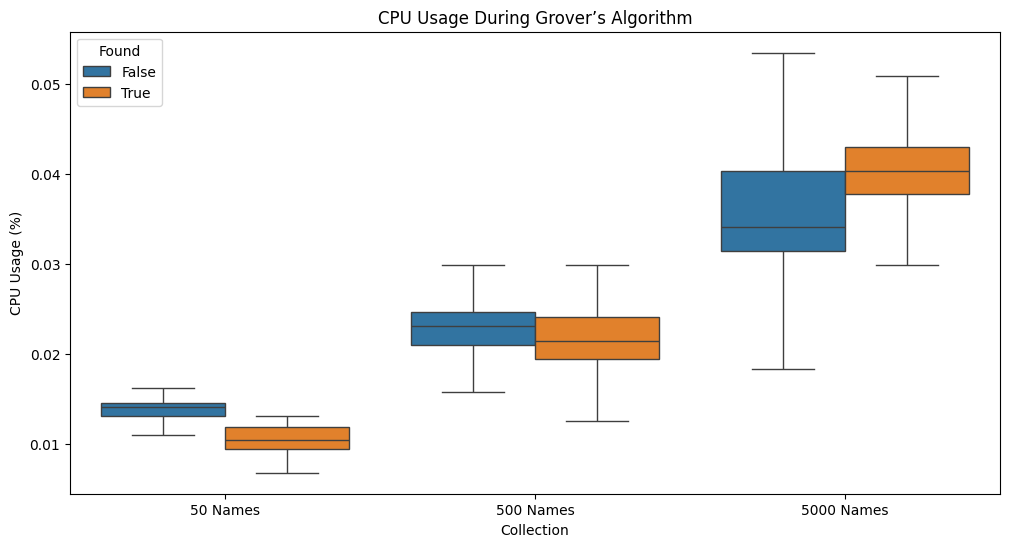

In [115]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Collection', y='CPU Usage (%)', hue='Found', data=df_all, showfliers=False)
plt.title('CPU Usage During Grover’s Algorithm')
plt.ylabel('CPU Usage (%)')
plt.show()

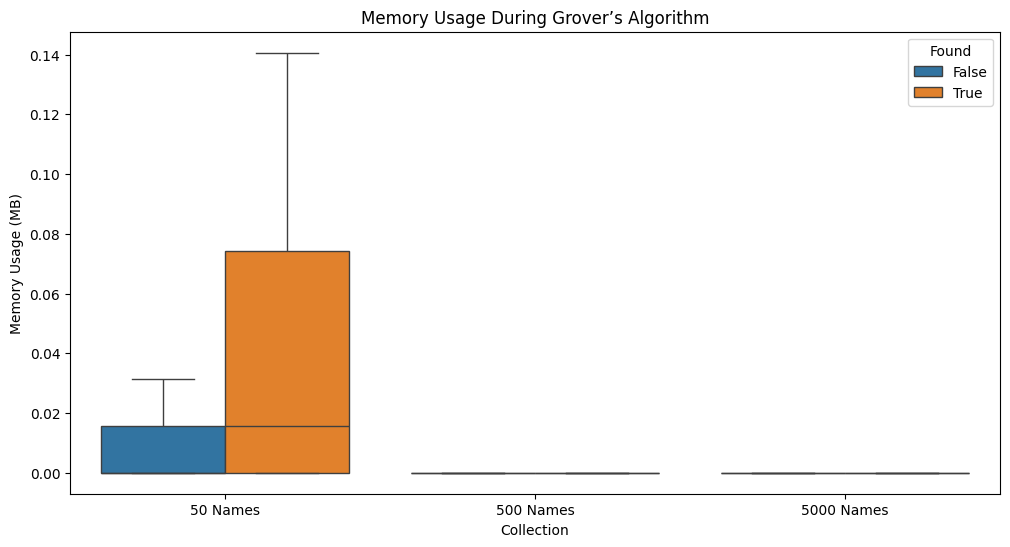

In [116]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Collection', y='Memory Usage (MB)', hue='Found', data=df_all, showfliers=False)
plt.title('Memory Usage During Grover’s Algorithm')
plt.ylabel('Memory Usage (MB)')
plt.show()


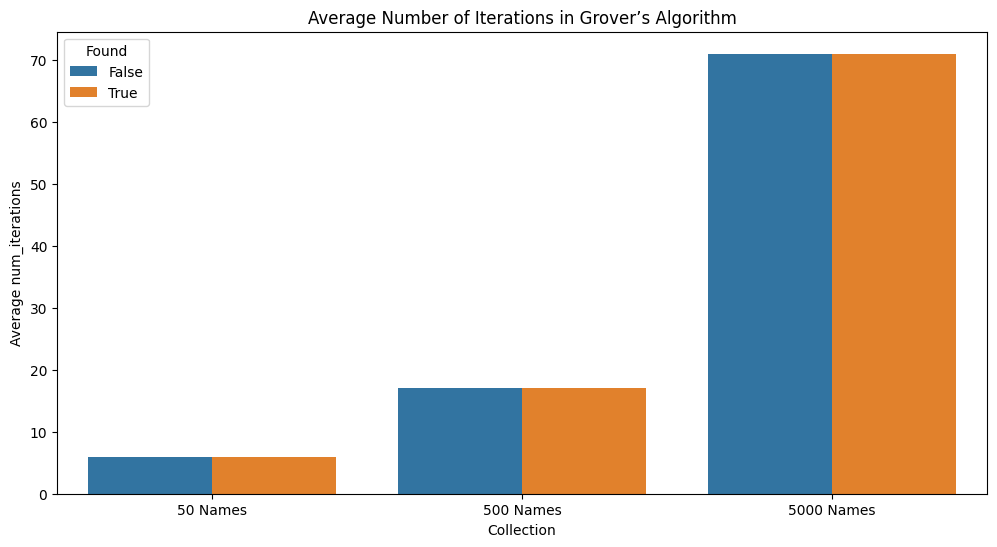

In [121]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Collection', y='num_iterations', hue='Found', data=df_all, estimator=np.mean, errorbar=None)
plt.title('Average Number of Iterations in Grover’s Algorithm')
plt.ylabel('Average num_iterations')
plt.xlabel('Collection')
plt.legend(title='Found')
plt.show()


### Statistical information

In [118]:
# Function to calculate and print stats for Time, CPU Usage, Memory Usage, and num_iterations
def print_stats(collection_name, df):
    print(f"\nStatistics for {collection_name}:")

    # Metrics to track
    metrics = ['Time Taken (seconds)', 'CPU Usage (%)', 'Memory Usage (MB)', 'num_iterations']

    for metric in metrics:
        # Calculate relevant stats
        mean = df[metric].mean()
        median = df[metric].median()
        std_dev = df[metric].std()
        min_val = df[metric].min()
        max_val = df[metric].max()
        iqr = df[metric].quantile(0.75) - df[metric].quantile(0.25)

        # Display the stats
        print(f"\n{metric}:")
        print(f"  Mean: {mean:.5f}")
        print(f"  Median: {median:.5f}")
        print(f"  Std Dev: {std_dev:.5f}")
        print(f"  Min: {min_val:.5f}")
        print(f"  Max: {max_val:.5f}")
        print(f"  IQR: {iqr:.5f}")

# Function to perform Mann-Whitney U test for each metric
def mann_whitney_test(collection_df, metric):
    found_values = collection_df[collection_df['Found'] == True][metric]
    not_found_values = collection_df[collection_df['Found'] == False][metric]
    
    if len(found_values) == 0 or len(not_found_values) == 0:
        return None  # Avoid performing test if there's not enough data
    
    stat, p_value = mannwhitneyu(found_values, not_found_values, alternative='two-sided')
    return p_value

# Print statistics for each dataset
print_stats('grover_search_50', df_grover_50)
print_stats('grover_search_500', df_grover_500)
print_stats('grover_search_5000', df_grover_5000)

# Perform Mann-Whitney U test for each metric
metrics = ['Time Taken (seconds)', 'CPU Usage (%)', 'Memory Usage (MB)', 'num_iterations']

print("\nMann-Whitney U Test Results (P-Values):")
for metric in metrics:
    p_value_50 = mann_whitney_test(df_grover_50, metric)
    p_value_500 = mann_whitney_test(df_grover_500, metric)
    p_value_5000 = mann_whitney_test(df_grover_5000, metric)
    
    print(f"\nMetric: {metric}")
    print(f"  P-Value for grover_search_50: {p_value_50:.5f}" if p_value_50 is not None else "  Not enough data")
    print(f"  P-Value for grover_search_500: {p_value_500:.5f}" if p_value_500 is not None else "  Not enough data")
    print(f"  P-Value for grover_search_5000: {p_value_5000:.5f}" if p_value_5000 is not None else "  Not enough data")



Statistics for grover_search_50:

Time Taken (seconds):
  Mean: 0.00191
  Median: 0.00184
  Std Dev: 0.00085
  Min: 0.00132
  Max: 0.00952
  IQR: 0.00045

CPU Usage (%):
  Mean: 0.01235
  Median: 0.01206
  Std Dev: 0.00271
  Min: 0.00524
  Max: 0.02202
  IQR: 0.00367

Memory Usage (MB):
  Mean: 0.15141
  Median: 0.01562
  Std Dev: 0.87324
  Min: 0.00000
  Max: 8.28125
  IQR: 0.03125

num_iterations:
  Mean: 6.00000
  Median: 6.00000
  Std Dev: 0.00000
  Min: 6.00000
  Max: 6.00000
  IQR: 0.00000

Statistics for grover_search_500:

Time Taken (seconds):
  Mean: 0.00288
  Median: 0.00269
  Std Dev: 0.00116
  Min: 0.00213
  Max: 0.02376
  IQR: 0.00045

CPU Usage (%):
  Mean: 0.02282
  Median: 0.02254
  Std Dev: 0.00545
  Min: 0.00786
  Max: 0.10224
  IQR: 0.00419

Memory Usage (MB):
  Mean: 0.00237
  Median: 0.00000
  Std Dev: 0.01358
  Min: 0.00000
  Max: 0.15625
  IQR: 0.00000

num_iterations:
  Mean: 17.00000
  Median: 17.00000
  Std Dev: 0.00000
  Min: 17.00000
  Max: 17.00000
  IQR: